In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')
pd.options.display.float_format = '{:.3f}'.format

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Final Capstone
## Predicting Taxi Fares in New York City
   My final capstone will work to predict taxi fare prices throughout New York City using data that includes GPS coordinates from pickup and dropoff locations, fare prices of each ride, and the number of riders of each ride. This would be useful for taxi fare companies who seek to stay competitive with rideshare companies like Uber and Lyft. Examination of the data will allow for insight into the time of day where taxi cabs are most used allowing for the deploying of the optimal amount of taxi drivers. Popular drop off/pick up points could be examined to provide more space at heavily trafficked drop off zones.

The dataset can be found on Kaggle [1]. The dataset is rather large with over 55 million rows of data. The dataset contains rides between 2009 and 2015. Sample data by a percentage 

https://developers.google.com/maps/documentation/distance-matrix/start

Figure out congestion time split dummy variables
12-4
4-8
8-12
12-4
8-12

Possible research Questions

- 
- What machine learning technique is best 

In [2]:
#taxi_test_data = pd.read_csv(r'C:\\Users\\david\Final Capstone\\NYC Taxi Data\\test.csv')
taxi_train_data = pd.read_csv(r'C:\\Users\\david\Final Capstone\\NYC Taxi Data\\train.csv', nrows = 2_750_000)

#using 5% of the data
#C:\Users\david\Final Capstone\NYC Taxi Data

In [3]:
#X_train, X_test = train_test_split(taxi_train_data, test_size=0.4, random_state=0)

In [4]:
#taxi_test_data.dtypes

In [5]:
null_count = taxi_train_data.isnull().sum()
null_count[null_count>0]

dropoff_longitude    22
dropoff_latitude     22
dtype: int64

In [6]:
taxi_train_data = taxi_train_data.dropna(how ='any', axis = 'rows')

In [7]:
taxi_train_data = taxi_train_data.drop(['key','passenger_count'], axis=1)

In [8]:
taxi_train_data.shape

(2749978, 6)

In [9]:
taxi_train_data.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  2749978.000       2749978.000      2749978.000        2749978.000   
mean        11.340           -72.517           39.926            -72.517   
std          9.828            13.153            8.513             12.808   
min        -62.000         -3426.609        -3488.080          -3408.430   
25%          6.000           -73.992           40.735            -73.991   
50%          8.500           -73.982           40.753            -73.980   
75%         12.500           -73.967           40.767            -73.964   
max       1273.310          3439.426         2912.465           3414.307   

       dropoff_latitude  
count       2749978.000  
mean             39.921  
std              10.155  
min           -3488.080  
25%              40.734  
50%              40.753  
75%              40.768  
max            3345.917

It looks like there are some extreme outliers in the case of latitude and longitude. Let's bound everything so it includes datapoints that are within New York City. The min is about -74 for longitude and about 41 for latitude. Let's create a function that adds 5 degrees. 

https://www.mapdevelopers.com/geocode_bounding_box.php

In [10]:
-74.5, -72.8, 40.5, 41.8

def clean_df(taxi_train_data):
    return taxi_train_data[(taxi_train_data.pickup_longitude > -74.259090) & (taxi_train_data.pickup_longitude < -73.70072) &
        (taxi_train_data.pickup_latitude > 40.477399 ) & (taxi_train_data.pickup_latitude < 40.917577) &
        (taxi_train_data.dropoff_longitude > -74.259090) & (taxi_train_data.dropoff_longitude < -73.70072) &
        (taxi_train_data.dropoff_latitude > 40.477399 ) & (taxi_train_data.dropoff_latitude < 40.917577)] 

taxi_train_data = clean_df(taxi_train_data)
print(len(taxi_train_data))

2688786


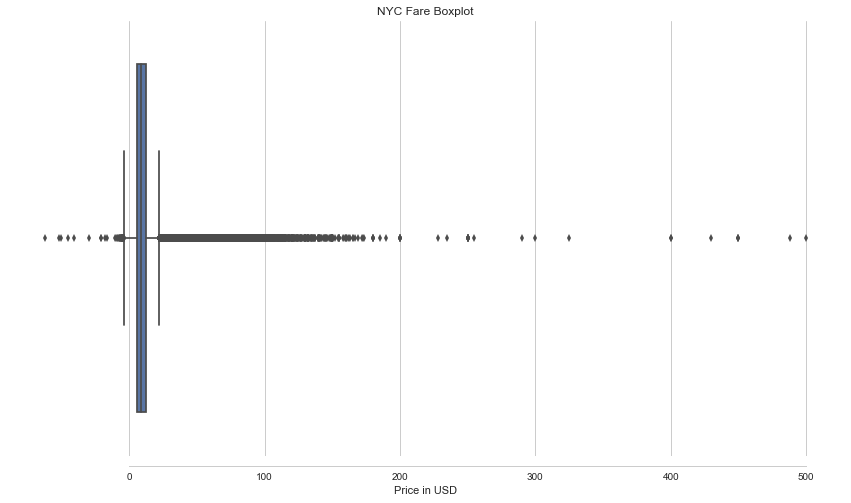

In [11]:
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")

ax = sns.boxplot(x=taxi_train_data['fare_amount'])  

plt.title('NYC Fare Boxplot')

sns.despine(offset=10, trim=True)
ax.set(xlabel='Price in USD', ylabel='')

plt.show()

The fare data also has some extreme outliers with the max being a little over $ 1,200. Also, it seems that there were some negative fares where people were paid to ride in the taxis? Let's remove those and bound it to $ 2.50 and $ 100. $ 2.50 is the minimum cab fare in NYC

In [12]:
#fix the outliers
taxi_train_data = taxi_train_data[taxi_train_data['fare_amount'].between(left = 2.5, right = 100)]

In [13]:
taxi_train_data.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  2688143.000       2688143.000      2688143.000        2688143.000   
mean        11.260           -73.976           40.751            -73.975   
std          9.309             0.034            0.027              0.034   
min          2.500           -74.259           40.483            -74.259   
25%          6.000           -73.992           40.737            -73.992   
50%          8.500           -73.982           40.753            -73.981   
75%         12.500           -73.968           40.767            -73.965   
max        100.000           -73.701           40.917            -73.701   

       dropoff_latitude  
count       2688143.000  
mean             40.751  
std               0.031  
min              40.478  
25%              40.736  
50%              40.754  
75%              40.768  
max              40.918

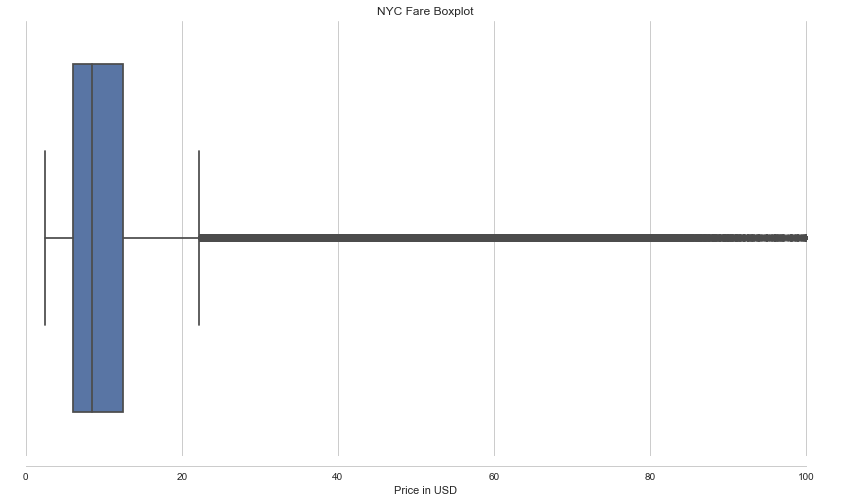

In [14]:
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")

ax = sns.boxplot(x=taxi_train_data['fare_amount'])  

plt.title('NYC Fare Boxplot')

sns.despine(offset=10, trim=True)
ax.set(xlabel='Price in USD', ylabel='')

plt.show()

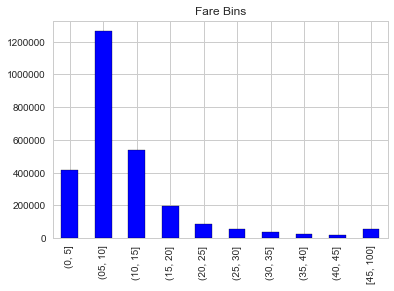

In [15]:
# Bin the fare and convert to string
taxi_train_data['fare-bin'] = pd.cut(taxi_train_data['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
taxi_train_data.loc[taxi_train_data['fare-bin'] == 'nan', 'fare-bin'] = '[45, 100]'

# Adjust bin so the sorting is correct
taxi_train_data.loc[taxi_train_data['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

# Bar plot of value counts
taxi_train_data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Bins');

In [16]:
taxi_train_data = taxi_train_data.drop(['fare-bin'], axis=1)

In [17]:
taxi_train_data.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  2688143.000       2688143.000      2688143.000        2688143.000   
mean        11.260           -73.976           40.751            -73.975   
std          9.309             0.034            0.027              0.034   
min          2.500           -74.259           40.483            -74.259   
25%          6.000           -73.992           40.737            -73.992   
50%          8.500           -73.982           40.753            -73.981   
75%         12.500           -73.968           40.767            -73.965   
max        100.000           -73.701           40.917            -73.701   

       dropoff_latitude  
count       2688143.000  
mean             40.751  
std               0.031  
min              40.478  
25%              40.736  
50%              40.754  
75%              40.768  
max              40.918

## Feature Engineering
#### Time and Date Features
Creating columns for:
- Year
- Month
- Day
- Hour
- Day of the Week

#### Distance Feature
Distance:
- Distance from pickup and dropoff locations

In [18]:
"""def morning_rush (row):
    if (row['hour'] <= 9) and (row['hour'] >= 6) and (row['weekday'] < 5):
        return 1
    else:
        return 0"""
"""
def mid_day (row):
    if (row['hour'] <= 15) and (row['hour'] >= 10):
        return 1
    else:
        return 0 
    
def late_night (row):
    if (row['hour'] <= 5) or (row['hour'] >= 20):
        return 1
    else:
        return 0    
    
    
def night_rush (row):
    if ((row['hour'] <= 20) and (row['hour'] >= 15)) and (row['weekday'] < 5):
        return 1
    else:
        return 0"""

def add_time_features(taxi_train_data):
    taxi_train_data['pickup_datetime'] =  pd.to_datetime(taxi_train_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    taxi_train_data['year'] = taxi_train_data['pickup_datetime'].apply(lambda x: x.year)
    taxi_train_data['month'] = taxi_train_data['pickup_datetime'].apply(lambda x: x.month)
    taxi_train_data['day'] = taxi_train_data['pickup_datetime'].apply(lambda x: x.day)
    taxi_train_data['hour'] = taxi_train_data['pickup_datetime'].apply(lambda x: x.hour)
    taxi_train_data['weekday'] = taxi_train_data['pickup_datetime'].apply(lambda x: x.weekday())
    #taxi_train_data['pickup_datetime'] =  taxi_train_data['pickup_datetime'].apply(lambda x: str(x))

    taxi_train_data = taxi_train_data.drop('pickup_datetime', axis=1)
    
    return taxi_train_data

def add_coordinate_features(taxi_train_data):
    lat1 = taxi_train_data['pickup_latitude']
    lat2 = taxi_train_data['dropoff_latitude']
    lon1 = taxi_train_data['pickup_longitude']
    lon2 = taxi_train_data['dropoff_longitude']
    
    # Add new features
    taxi_train_data['latdiff'] = (lat1 - lat2)
    taxi_train_data['londiff'] = (lon1 - lon2)

    return taxi_train_data


def add_distances_features(taxi_train_data):

    lat1 = taxi_train_data['pickup_latitude']
    lat2 = taxi_train_data['dropoff_latitude']
    lon1 = taxi_train_data['pickup_longitude']
    lon2 = taxi_train_data['dropoff_longitude']
    
    taxi_train_data['distance_traveled'] = (taxi_train_data['latdiff'] ** 2 + taxi_train_data['londiff'] ** 2) ** 0.5
    
    return taxi_train_data


In [19]:

taxi_train_data = add_time_features(taxi_train_data)
#taxi_train_data = add_time_features(taxi_train_data)

add_coordinate_features(taxi_train_data)
#add_coordinate_features(taxi_train_data)

taxi_train_data = add_distances_features(taxi_train_data)
#taxi_train_data = add_distances_features(taxi_train_data)

taxi_train_data.head(5)

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0        4.500           -73.844           40.721            -73.842   
1       16.900           -74.016           40.711            -73.979   
2        5.700           -73.983           40.761            -73.991   
3        7.700           -73.987           40.733            -73.992   
4        5.300           -73.968           40.768            -73.957   

   dropoff_latitude  year  month  day  hour  weekday  latdiff  londiff  \
0            40.712  2009      6   15    17        0    0.009   -0.003   
1            40.782  2010      1    5    16        1   -0.071   -0.037   
2            40.751  2011      8   18     0        3    0.011    0.009   
3            40.758  2012      4   21     4        5   -0.025    0.004   
4            40.784  2010      3    9     7        1   -0.016   -0.011   

   distance_traveled  
0              0.009  
1              0.080  
2              0.014  
3              0.025  
4              0.019

In [20]:
taxi_train_data.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0        4.500           -73.844           40.721            -73.842   
1       16.900           -74.016           40.711            -73.979   
2        5.700           -73.983           40.761            -73.991   
3        7.700           -73.987           40.733            -73.992   
4        5.300           -73.968           40.768            -73.957   

   dropoff_latitude  year  month  day  hour  weekday  latdiff  londiff  \
0            40.712  2009      6   15    17        0    0.009   -0.003   
1            40.782  2010      1    5    16        1   -0.071   -0.037   
2            40.751  2011      8   18     0        3    0.011    0.009   
3            40.758  2012      4   21     4        5   -0.025    0.004   
4            40.784  2010      3    9     7        1   -0.016   -0.011   

   distance_traveled  
0              0.009  
1              0.080  
2              0.014  
3              0.025  
4              0.019

## Taxi Cab Ride Frequency by hour

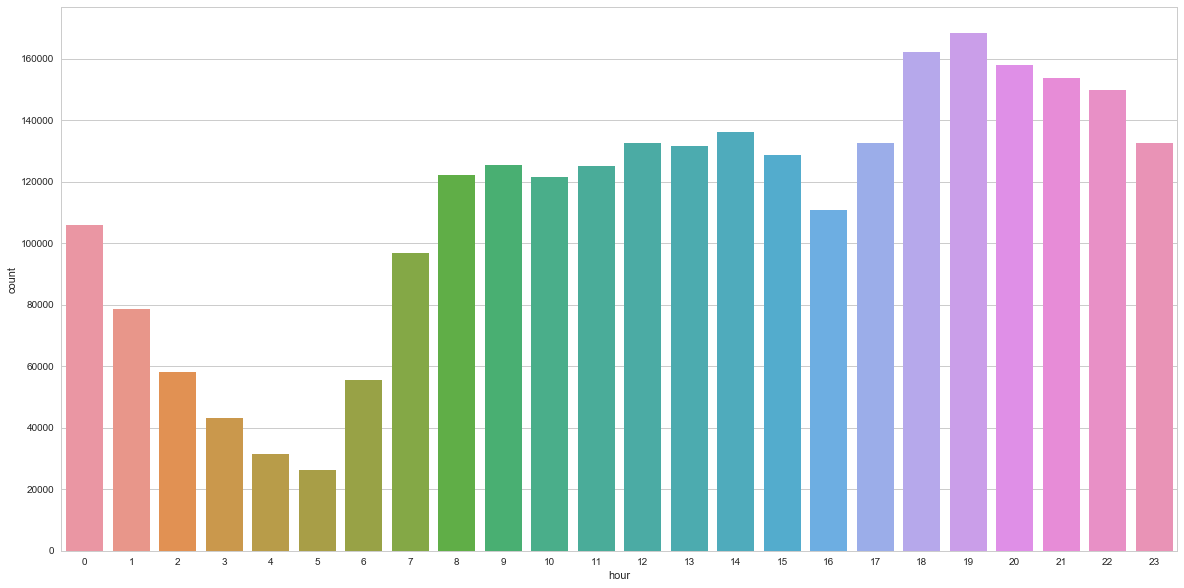

In [21]:
plt.figure(figsize=(20, 10))
n_freq=taxi_train_data['hour'].value_counts()
n_freq

n_df = pd.DataFrame({'hour':n_freq.index ,'count':n_freq.values})
n_df

sns.barplot(x='hour', y='count', data=n_df)


## Taxi Cab Ride Frequency by Month

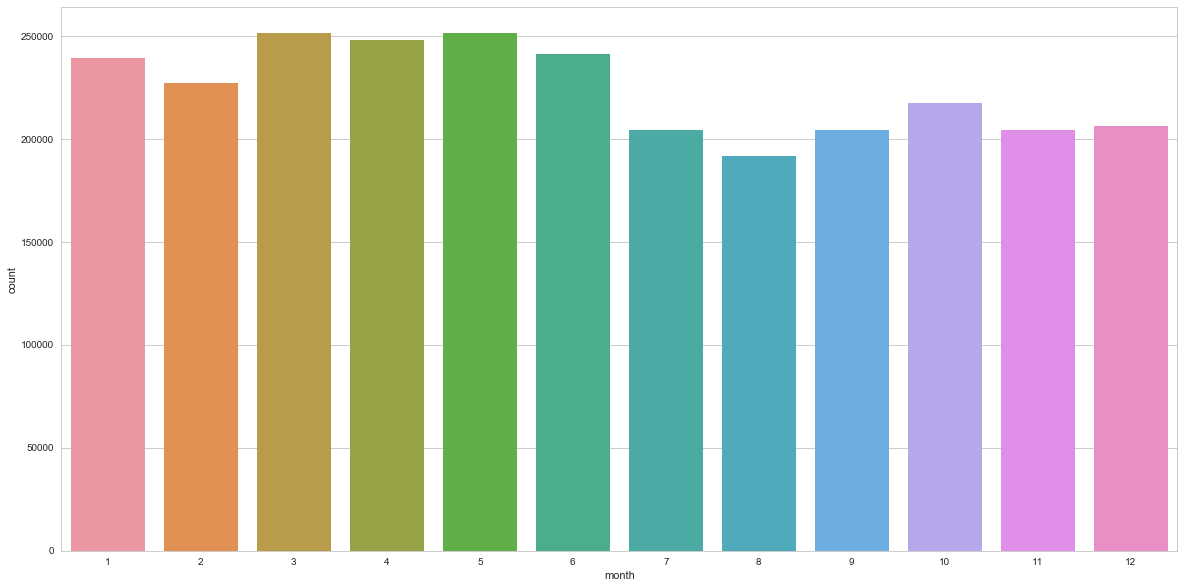

In [22]:
plt.figure(figsize=(20, 10))
n_freq=taxi_train_data['month'].value_counts()
n_freq

n_month = pd.DataFrame({'month':n_freq.index ,'count':n_freq.values})
n_month

sns.barplot(x='month', y='count', data=n_month)


## Taxi Cab Ride Frequency by Day of Week

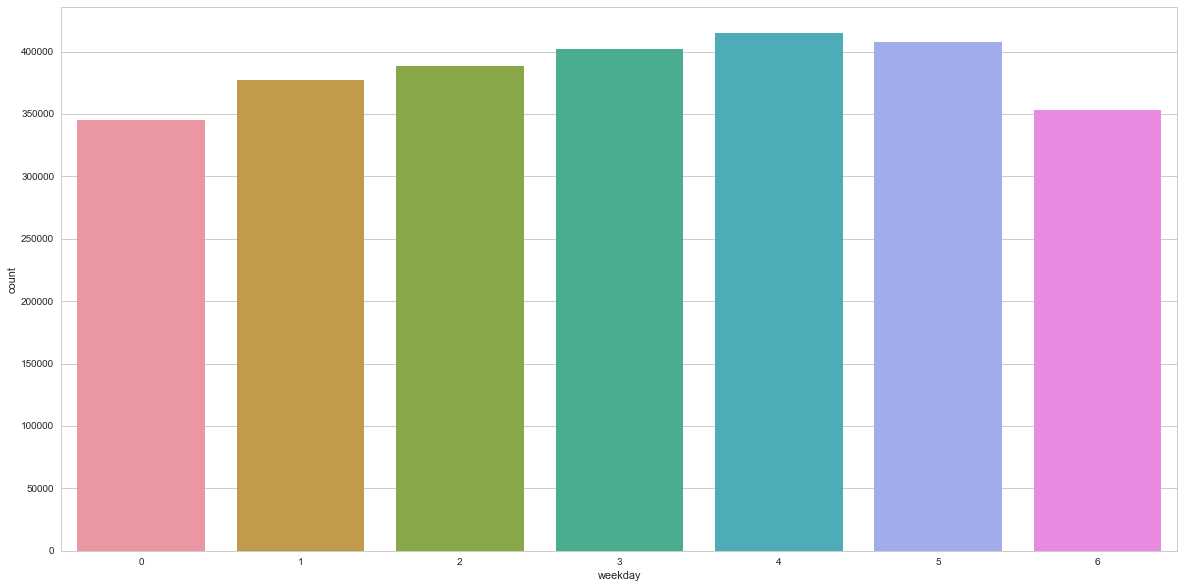

In [23]:
plt.figure(figsize=(20, 10))
n_freq=taxi_train_data['weekday'].value_counts()
n_freq

n_weekday = pd.DataFrame({'weekday':n_freq.index ,'count':n_freq.values})
n_weekday

sns.barplot(x='weekday', y='count', data=n_weekday)


In [24]:
plt.figure(figsize=(20, 10))
n_freq=taxi_train_data['year'].value_counts()
n_freq

n_year = pd.DataFrame({'year':n_freq.index ,'count':n_freq.values})
n_year

sns.barplot(x='year', y='count', data=n_year
)


In [25]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (taxi_train_data.pickup_longitude >= BB[0]) & (taxi_train_data.pickup_longitude <= BB[1]) & \
           (taxi_train_data.pickup_latitude >= BB[2]) & (taxi_train_data.pickup_latitude <= BB[3]) & \
           (taxi_train_data.dropoff_longitude >= BB[0]) & (taxi_train_data.dropoff_longitude <= BB[1]) & \
           (taxi_train_data.dropoff_latitude >= BB[2]) & (taxi_train_data.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [26]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(taxi_train_data.pickup_longitude, taxi_train_data.pickup_latitude, zorder=1, alpha=alpha, c='y', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(taxi_train_data.dropoff_longitude, taxi_train_data.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

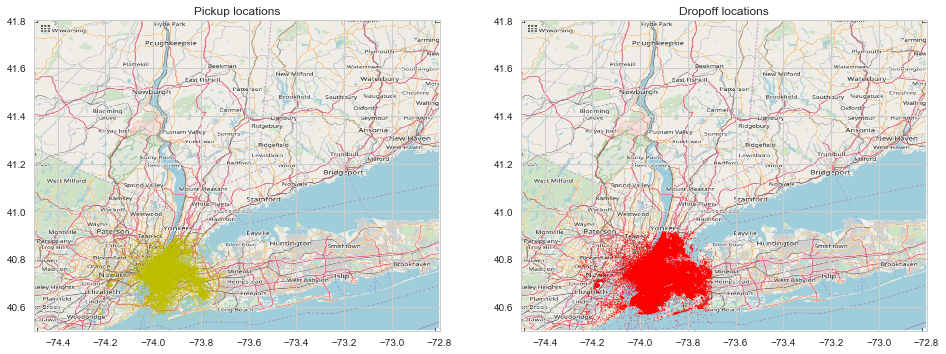

In [27]:
plot_on_map(taxi_train_data, BB, nyc_map, s=1, alpha=0.3)

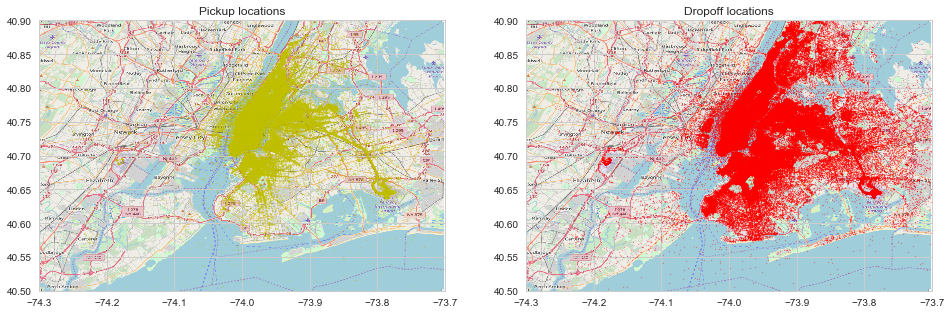

In [28]:
# plot training data on map zoomed in
plot_on_map(taxi_train_data, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

In [29]:
def plot_hires(taxi_train_data, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(taxi_train_data, BB)
    ax.scatter(taxi_train_data[idx].pickup_longitude, taxi_train_data[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(taxi_train_data[idx].dropoff_longitude, taxi_train_data[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)

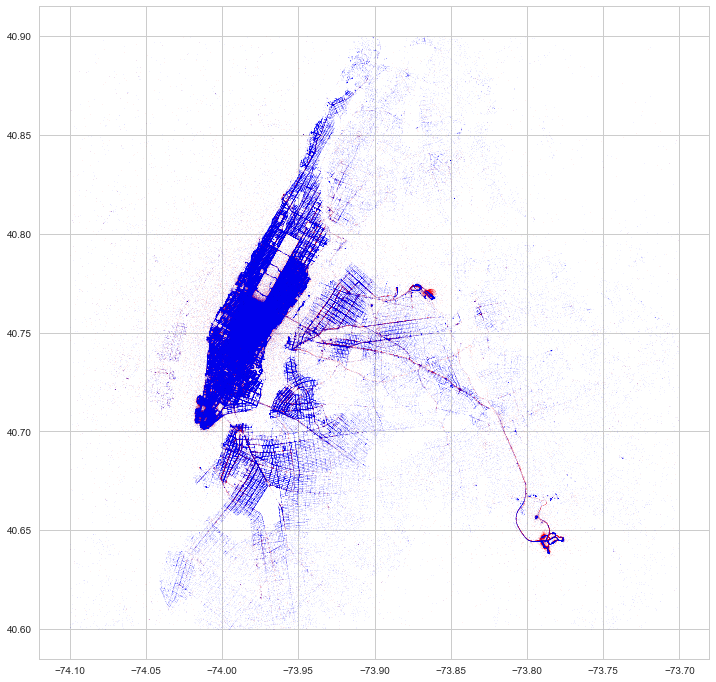

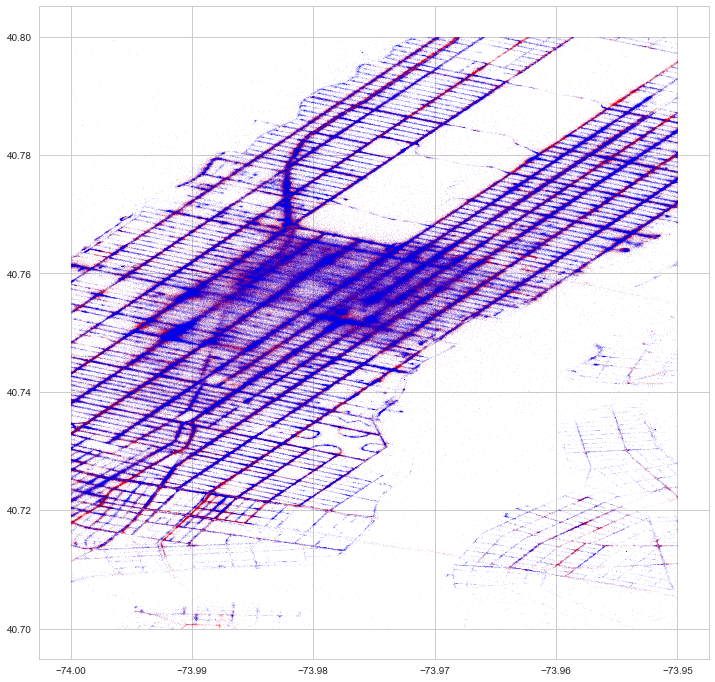

In [30]:
plot_hires(taxi_train_data, (-74.1, -73.7, 40.6, 40.9))
plot_hires(taxi_train_data, (-74, -73.95, 40.7, 40.8))

In [31]:
import folium

lat_center_jfk = 40.645626
lon_center_jfk = -73.785220

map_jfk_pk = folium.Map(location=[lat_center_jfk,lon_center_jfk],
                         tiles="OpenStreetMap",
                         max_zoom=15,zoom_start=15)

folium.Marker(location = [lat_center_jfk,lon_center_jfk],
              icon = folium.Icon( icon="star",color = "blue")).add_to(map_jfk_pk)

#plotting 2500 dta points
for i in range(0,len(taxi_train_data[:10000])) :
    p = [taxi_train_data["pickup_latitude"][:10000].values[i],
        taxi_train_data["pickup_longitude"][:10000].values[i]]
    
    folium.Circle(location = p ,radius = 2,
                  color = "red").add_to(map_jfk_pk)
    

map_jfk_pk

In [32]:
"""dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
taxi_train_data['weekday'] = taxi_train_data['weekday'].map(dayOfWeek)"""

"dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}\ntaxi_train_data['weekday'] = taxi_train_data['weekday'].map(dayOfWeek)"

In [33]:
"""taxi_train_data = taxi_train_data.join(pd.get_dummies(taxi_train_data['hour']))"""

"taxi_train_data = taxi_train_data.join(pd.get_dummies(taxi_train_data['hour']))"

In [34]:
"""taxi_train_data = taxi_train_data.join(pd.get_dummies(taxi_train_data['weekday']))"""

"taxi_train_data = taxi_train_data.join(pd.get_dummies(taxi_train_data['weekday']))"

In [35]:
"""taxi_train_data = taxi_train_data.drop( 'weekday', axis=1)"""

"taxi_train_data = taxi_train_data.drop( 'weekday', axis=1)"

In [36]:
taxi_train_data.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0        4.500           -73.844           40.721            -73.842   
1       16.900           -74.016           40.711            -73.979   
2        5.700           -73.983           40.761            -73.991   
3        7.700           -73.987           40.733            -73.992   
4        5.300           -73.968           40.768            -73.957   

   dropoff_latitude  year  month  day  hour  weekday  latdiff  londiff  \
0            40.712  2009      6   15    17        0    0.009   -0.003   
1            40.782  2010      1    5    16        1   -0.071   -0.037   
2            40.751  2011      8   18     0        3    0.011    0.009   
3            40.758  2012      4   21     4        5   -0.025    0.004   
4            40.784  2010      3    9     7        1   -0.016   -0.011   

   distance_traveled  
0              0.009  
1              0.080  
2              0.014  
3              0.025  
4              0.019

In [37]:
taxi_train_data.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'year', 'month', 'day', 'hour',
       'weekday', 'latdiff', 'londiff', 'distance_traveled'],
      dtype='object')

In [38]:
"""taxi_train_data = taxi_train_data.drop( ['month','day','year', 'hour', 'latdiff','londiff'], axis=1)"""

"taxi_train_data = taxi_train_data.drop( ['month','day','year', 'hour', 'latdiff','londiff'], axis=1)"

In [39]:
taxi_train_data = taxi_train_data.drop( ['year', 'day', 'latdiff','londiff'], axis=1)

In [40]:
taxi_train_data.head(5)

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0        4.500           -73.844           40.721            -73.842   
1       16.900           -74.016           40.711            -73.979   
2        5.700           -73.983           40.761            -73.991   
3        7.700           -73.987           40.733            -73.992   
4        5.300           -73.968           40.768            -73.957   

   dropoff_latitude  month  hour  weekday  distance_traveled  
0            40.712      6    17        0              0.009  
1            40.782      1    16        1              0.080  
2            40.751      8     0        3              0.014  
3            40.758      4     4        5              0.025  
4            40.784      3     7        1              0.019

In [41]:
#random.seed()

#import random

#random.seed(n)

In [42]:
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



# Normalize the data.
"""X_norm = normalize(X)"""
X_cluster = taxi_train_data.copy()

mms = MinMaxScaler()
mms.fit(X_cluster)
data_transformed = mms.transform(X_cluster)

# Split the data into four equally-sized samples. First we break it in half:
"""X_half1, X_half2 = train_test_split(
    X_norm,
    test_size=0.5,
    random_state=None)
X1, X2 = train_test_split(
    X_half1,
    test_size=0.5,
    random_state=None)
X3, X4  = train_test_split(
    X_half2,
    test_size=0.5,
    random_state=None)"""

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2 = train_test_split(
    data_transformed,
    test_size=0.5,
    random_state=42)
X1, X2 = train_test_split(
    X_half1,
    test_size=0.5,
    random_state=42)
X3, X4  = train_test_split(
    X_half2,
    test_size=0.5,
    random_state=42)


In [56]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,12)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

7 Clusters. Investigated silhouette score was .30

2 clusters. silhouette score was 


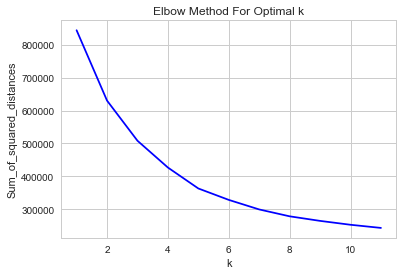

In [58]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [60]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
n_clusters = (2,3,4,5,6,7,8)
for n in n_clusters:
    print("Number of estimated clusters: {}".format(n))
    for sample in [data_transformed]:
        model = KMeans(n_clusters=n, random_state=42).fit(sample)
        labels = model.labels_
        print(metrics.silhouette_score(sample, labels, metric='euclidean', sample_size = 15000))

Number of estimated clusters: 2
0.23841637458255263
Number of estimated clusters: 3
0.23463647832185058
Number of estimated clusters: 4
0.24105487911061263
Number of estimated clusters: 5
0.24666489017796234
Number of estimated clusters: 6
0.24213644412790467
Number of estimated clusters: 7
0.23752058440783638
Number of estimated clusters: 8
0.22781646755972604


In [62]:
model = KMeans(n_clusters=8, random_state=42).fit(data_transformed)
labels = model.labels_
#print(metrics.silhouette_score(sample, labels, metric='euclidean'))

X_cluster['clusters_all_set'] = labels

In [64]:
X_clusters = X_cluster.groupby(['clusters_all_set'], as_index=False).mean()
print(X_clusters)

   clusters_all_set  fare_amount  pickup_longitude  pickup_latitude  \
0                 0       10.993           -73.975           40.752   
1                 1       11.508           -73.978           40.748   
2                 2       11.377           -73.975           40.750   
3                 3       11.179           -73.975           40.752   
4                 4       11.226           -73.978           40.749   
5                 5       11.474           -73.974           40.753   
6                 6       11.351           -73.975           40.751   
7                 7       11.146           -73.976           40.751   

   dropoff_longitude  dropoff_latitude  month   hour  weekday  \
0            -73.975            40.753  3.691 18.106    0.946   
1            -73.972            40.749  9.535  5.072    4.827   
2            -73.976            40.751  9.558 17.664    4.923   
3            -73.974            40.752  3.566  7.977    1.663   
4            -73.973            40.

In [66]:
import folium
#-74.5, -72.8, 40.5, 41.8
lat_center_nyc = 40.7128
lon_center_nyc = -74.0060

map_nyc_pk = folium.Map(location=[lat_center_nyc,lon_center_nyc],
                         tiles="OpenStreetMap",
                         max_zoom=15,zoom_start=15)

folium.Marker(location = [lat_center_nyc,lon_center_nyc],
              icon = folium.Icon( icon="star",color = "blue")).add_to(map_nyc_pk)

#plotting 2500 dta points
for i in range(0,len(X_cluster)) :
    p = [X_cluster["pickup_latitude"].values[i],
        X_cluster["pickup_longitude"].values[i]]
    
    folium.Circle(location = p ,radius = 2,
                  color = "red").add_to(map_nyc_pk)
    

map_nyc_pk

Text(0.5,1,'Fare Price by Cluster')

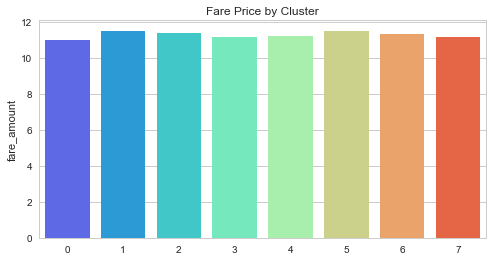

In [68]:
s = X_cluster.groupby(['clusters_all_set'], as_index=False).mean()['fare_amount']
g = sns.barplot(s.index, s, palette='rainbow')
g.figure.set_size_inches(8,4)
g.set_title("Fare Price by Cluster")

## Geoclustering

In [70]:

"""Cluster by 
time of day
day of week
location"""



X_locdf = taxi_train_data.copy()
X_loc = X_locdf[['pickup_longitude', 'pickup_latitude']]


#Show final feature count that goes into model
print('Location Feature Set has a shape of: {}'.format(X1.shape))



#Determine number of clusters using elbow plot
X_loc_norm = normalize(X_loc)

Location Feature Set has a shape of: (672035, 9)


In [71]:



def elbow_curve(ModX):
    
    differences = []
    for k in range(1, 12):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(ModX)
        differences.append(kmeans.inertia_)

    plt.figure(figsize=(15, 5))
    plt.plot(range(1, 12), differences)
    plt.xticks(np.arange(0, 31, 1))
    plt.grid(True)
    plt.title('Clusters Elbow Curve')

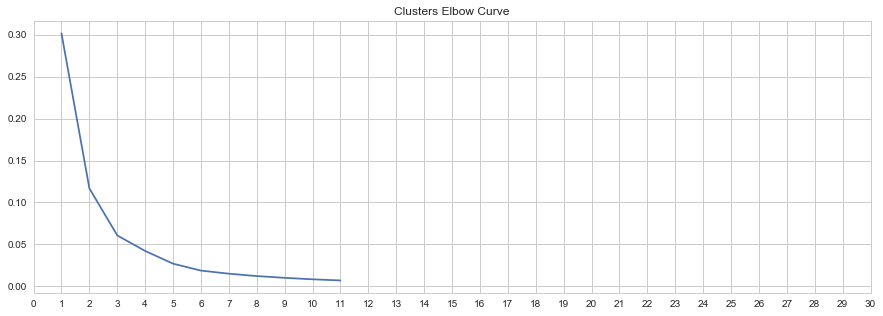

In [72]:

#Run on attendance
elbow_curve(X_loc_norm)

In [73]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
n_clusters = (2,5,6,7, 10, 15, 20)
for n in n_clusters:
    print("Number of estimated clusters: {}".format(n))
    for sample in [X_loc_norm]:
        model = KMeans(n_clusters=n, random_state=42).fit(sample)
        labels = model.labels_
        print(metrics.silhouette_score(sample, labels, metric='euclidean', sample_size = 15000))

Number of estimated clusters: 2
0.5420975913178612
Number of estimated clusters: 5
0.5499321114369361
Number of estimated clusters: 6
0.5503822486424947
Number of estimated clusters: 7
0.5302800741011433
Number of estimated clusters: 10
0.5487167620835911
Number of estimated clusters: 15
0.540267069826879
Number of estimated clusters: 20
0.5464238118595189


In [74]:
"""# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=5,
    batch_size=200)
minibatchkmeans.fit(X_loc_norm)

y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X_loc_norm)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_loc_norm)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))"""

"# Each batch will be made up of 200 data points.\nminibatchkmeans = MiniBatchKMeans(\n    init='random',\n    n_clusters=5,\n    batch_size=200)\nminibatchkmeans.fit(X_loc_norm)\n\ny_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X_loc_norm)\n\n# Add the new predicted cluster memberships to the data frame.\npredict_mini = minibatchkmeans.predict(X_loc_norm)\n\n# Check the MiniBatch model against our earlier one.\nprint('Comparing k-means and mini batch k-means solutions:')\nprint(pd.crosstab(predict_mini, y_pred))"

In [75]:
model = KMeans(n_clusters=6, random_state=42).fit(X_loc_norm)
labels = model.labels_
#print(metrics.silhouette_score(sample, labels, metric='euclidean'))

X_locdf['clusters_loc'] = labels

In [76]:

X_loc_clusters = X_locdf.groupby(['clusters_loc'], as_index=False).mean()
print(X_loc_clusters)

   clusters_loc  fare_amount  pickup_longitude  pickup_latitude  \
0             0        9.995           -73.959           40.779   
1             1       10.253           -73.994           40.731   
2             2       10.809           -73.971           40.760   
3             3       13.307           -74.004           40.706   
4             4       20.661           -73.909           40.790   
5             5       11.359           -73.979           40.745   

   dropoff_longitude  dropoff_latitude  month   hour  weekday  \
0            -73.966            40.767  6.252 13.459    2.985   
1            -73.983            40.739  6.260 12.855    3.300   
2            -73.972            40.757  6.263 14.044    2.892   
3            -73.984            40.729  6.315 13.508    3.100   
4            -73.956            40.767  6.342 13.927    2.966   
5            -73.977            40.748  6.270 13.549    2.991   

   distance_traveled  
0              0.029  
1              0.030  
2    

In [77]:
X_loc_clusters

clusters_loc  fare_amount  pickup_longitude  pickup_latitude  \
0             0        9.995           -73.959           40.779   
1             1       10.253           -73.994           40.731   
2             2       10.809           -73.971           40.760   
3             3       13.307           -74.004           40.706   
4             4       20.661           -73.909           40.790   
5             5       11.359           -73.979           40.745   

   dropoff_longitude  dropoff_latitude  month   hour  weekday  \
0            -73.966            40.767  6.252 13.459    2.985   
1            -73.983            40.739  6.260 12.855    3.300   
2            -73.972            40.757  6.263 14.044    2.892   
3            -73.984            40.729  6.315 13.508    3.100   
4            -73.956            40.767  6.342 13.927    2.966   
5            -73.977            40.748  6.270 13.549    2.991   

   distance_traveled  
0              0.029  
1              0.030  
2              0.032  
3              0.042  
4              0.071  
5              0.034

In [78]:
import folium
#-74.5, -72.8, 40.5, 41.8
lat_center_nyc = 40.7128
lon_center_nyc = -74.0060

map_nyc_pk = folium.Map(location=[lat_center_nyc,lon_center_nyc],
                         tiles="OpenStreetMap",
                         max_zoom=15,zoom_start=15)


#plotting 2500 dta points
for i in range(0,len(X_loc_clusters)) :
    p = [X_loc_clusters["pickup_latitude"].values[i],
        X_loc_clusters["pickup_longitude"].values[i]]
    
    folium.Circle(location = p ,radius = 4,
                  color = "red").add_to(map_nyc_pk)
    

map_nyc_pk

In [79]:
"""cluster_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X)
X_pred = X.copy()
X_pred['cluster_assignment'] = cluster_pred

cluster_dataframes = {}
for n_clust in range(2):
    cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

for name, frame in cluster_dataframes.items():
    print(name)
    print(frame.describe())"""

"cluster_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X)\nX_pred = X.copy()\nX_pred['cluster_assignment'] = cluster_pred\n\ncluster_dataframes = {}\nfor n_clust in range(2):\n    cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]\n\nfor name, frame in cluster_dataframes.items():\n    print(name)\n    print(frame.describe())"

In [80]:
X_locdf.sort_values(by='fare_amount')

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
1219947        2.500           -73.970           40.752            -73.971   
2160915        2.500           -73.967           40.757            -73.969   
695087         2.500           -73.949           40.745            -73.949   
932504         2.500           -73.987           40.750            -73.987   
2459135        2.500           -73.871           40.774            -73.872   
1938644        2.500           -73.943           40.750            -73.943   
1758006        2.500           -73.970           40.752            -73.969   
533945         2.500           -74.001           40.726            -74.001   
1757887        2.500           -73.952           40.804            -73.952   
2043968        2.500           -73.961           40.598            -73.961   
839232         2.500           -73.975           40.762            -73.989   
1629572        2.500           -73.979           40.762            -73.978   
1938855        2.500           -73.985           40.761            -73.985   
640732         2.500           -74.004           40.730            -74.004   
270037         2.500           -73.777           40.645            -73.777   
225259         2.500           -73.972           40.646            -73.972   
1354296        2.500           -73.998           40.694            -73.998   
2161091        2.500           -73.970           40.752            -73.970   
1354334        2.500           -73.973           40.761            -73.974   
1486145        2.500           -73.991           40.725            -73.991   
1938934        2.500           -73.790           40.644            -73.790   
2611399        2.500           -73.990           40.762            -74.008   
1353983        2.500           -73.960           40.771            -73.927   
887168         2.500           -73.974           40.794            -73.973   
1074599        2.500           -74.008           40.743            -74.008   
1074482        2.500           -73.782           40.645            -73.781   
2459080        2.500           -73.969           40.764            -73.970   
2611134        2.500           -73.979           40.762            -73.979   
1012382        2.500           -73.953           40.767            -73.953   
2611155        2.500           -73.902           40.764            -73.902   
...              ...               ...              ...                ...   
2698186      100.000           -74.177           40.695            -74.177   
1340962      100.000           -74.005           40.875            -74.005   
2255883      100.000           -73.995           40.753            -74.193   
2423900      100.000           -73.983           40.678            -73.983   
670221       100.000           -74.199           40.853            -74.199   
621190       100.000           -74.209           40.793            -74.209   
120948       100.000           -74.177           40.695            -74.179   
2172192      100.000           -73.778           40.914            -73.778   
1953789      100.000           -73.993           40.763            -73.996   
2285806      100.000           -74.245           40.860            -74.245   
525308       100.000           -74.015           40.897            -74.015   
614428       100.000           -74.131           40.824            -74.131   
2649404      100.000           -73.969           40.763            -74.178   
222733       100.000           -74.177           40.695            -74.177   
1815107      100.000           -74.078           40.772            -74.078   
217609       100.000           -73.973           40.758            -73.873   
1538997      100.000           -74.224           40.818            -74.224   
951018       100.000           -73.982           40.776            -73.982   
991634       100.000           -73.982           40.760            -73.982   
1264251      100.000           

In [81]:
s = X_locdf.groupby(['clusters_loc'], as_index=False).mean()['fare_amount']
g = sns.barplot(s.index, s, palette='rainbow')
g.figure.set_size_inches(8,4)
g.set_title("Fare Price by Cluster")

Text(0.5,1,'Fare Price by Cluster')

##  Geo Clustering with DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

eps = [0.004, 0.005]   # unit: latitude/longitude
min_sample = [3, 4, 5]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n1, ncols=n2, figsize=(20, 15))

for i in range(n1):
    for j in range(n2):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric="euclidean").fit(X_loc)
        df_loc['cluster'] = est.labels_.tolist()

        ax = plt.subplot(n1, n2, n2*i+j+1)
        ax.set_title("DBSCAN ('euclidean', eps={}, min_sample={})".format(eps[i], min_sample[j]))
        
        plot_stations_map(ax, df_loc)

## Cluster by day of the week 

In [82]:

"""Cluster by 
time of day
day of week
location"""



X_daydf = taxi_train_data.copy()
X_day = X_daydf[["weekday"]]


#Show final feature count that goes into model
print('Location Feature Set has a shape of: {}'.format(X1.shape))



#Determine number of clusters using elbow plot
X_day_norm = normalize(X_day)

Location Feature Set has a shape of: (672035, 9)


In [83]:
taxi_train_data.head(5)

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0        4.500           -73.844           40.721            -73.842   
1       16.900           -74.016           40.711            -73.979   
2        5.700           -73.983           40.761            -73.991   
3        7.700           -73.987           40.733            -73.992   
4        5.300           -73.968           40.768            -73.957   

   dropoff_latitude  month  hour  weekday  distance_traveled  
0            40.712      6    17        0              0.009  
1            40.782      1    16        1              0.080  
2            40.751      8     0        3              0.014  
3            40.758      4     4        5              0.025  
4            40.784      3     7        1              0.019

In [84]:

#Run on attendance
elbow_curve(X_day)

In [85]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
n_clusters = (2,5,6,7, 10, 15, 20)
for n in n_clusters:
    print("Number of estimated clusters: {}".format(n))
    for sample in [X_day]:
        model = KMeans(n_clusters=n, random_state=42).fit(sample)
        labels = model.labels_
        print(metrics.silhouette_score(sample, labels, metric='euclidean', sample_size = 15000))

Number of estimated clusters: 2
0.6454194571099185
Number of estimated clusters: 5
0.7950762121613327
Number of estimated clusters: 6
0.899622542204568
Number of estimated clusters: 7
1.0
Number of estimated clusters: 10
1.0
Number of estimated clusters: 15
1.0
Number of estimated clusters: 20
1.0


In [86]:
model = KMeans(n_clusters=7, random_state=42).fit(X_day)
labels = model.labels_
#print(metrics.silhouette_score(sample, labels, metric='euclidean'))

X_daydf['clusters_loc'] = labels

In [87]:

X_day_clusters = X_daydf.groupby(['clusters_loc'], as_index=False).mean()
print(X_day_clusters)

   clusters_loc  fare_amount  pickup_longitude  pickup_latitude  \
0             0       11.320           -73.976           40.751   
1             1       11.226           -73.976           40.752   
2             2       11.563           -73.975           40.749   
3             3       10.925           -73.978           40.749   
4             4       11.106           -73.975           40.752   
5             5       11.423           -73.976           40.751   
6             6       11.293           -73.973           40.752   

   dropoff_longitude  dropoff_latitude  month   hour  weekday  \
0            -73.975            40.751  6.232 13.638    4.000   
1            -73.975            40.752  6.291 13.943    2.000   
2            -73.973            40.750  6.256 11.944    6.000   
3            -73.976            40.750  6.227 13.045    5.000   
4            -73.975            40.752  6.305 14.064    1.000   
5            -73.975            40.752  6.264 13.959    3.000   
6       

In [88]:
X_day_clusters

clusters_loc  fare_amount  pickup_longitude  pickup_latitude  \
0             0       11.320           -73.976           40.751   
1             1       11.226           -73.976           40.752   
2             2       11.563           -73.975           40.749   
3             3       10.925           -73.978           40.749   
4             4       11.106           -73.975           40.752   
5             5       11.423           -73.976           40.751   
6             6       11.293           -73.973           40.752   

   dropoff_longitude  dropoff_latitude  month   hour  weekday  \
0            -73.975            40.751  6.232 13.638    4.000   
1            -73.975            40.752  6.291 13.943    2.000   
2            -73.973            40.750  6.256 11.944    6.000   
3            -73.976            40.750  6.227 13.045    5.000   
4            -73.975            40.752  6.305 14.064    1.000   
5            -73.975            40.752  6.264 13.959    3.000   
6            -73.974            40.752  6.317 13.902    0.000   

   distance_traveled  
0              0.033  
1              0.033  
2              0.037  
3              0.033  
4              0.033  
5              0.034  
6              0.035

Text(0.5,1,'Fare Price by Cluster')

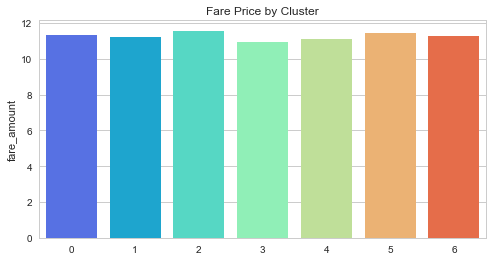

In [89]:
s = X_daydf.groupby(['clusters_loc'], as_index=False).mean()['fare_amount']
g = sns.barplot(s.index, s, palette='rainbow')
g.figure.set_size_inches(8,4)
g.set_title("Fare Price by Cluster")

In [90]:
import folium
#-74.5, -72.8, 40.5, 41.8
lat_center_nyc = 40.7128
lon_center_nyc = -74.0060

map_nyc_pk = folium.Map(location=[lat_center_nyc,lon_center_nyc],
                         tiles="OpenStreetMap",
                         max_zoom=15,zoom_start=15)


#plotting 2500 dta points
for i in range(0,len(X_day_clusters)) :
    p = [X_daydf["pickup_latitude"].values[i],
        X_daydf["pickup_longitude"].values[i]]
    
    folium.Circle(location = p ,radius = 4,
                  color = "red").add_to(map_nyc_pk)
    

map_nyc_pk

In [91]:

"""Cluster by 
time of day
day of week
location"""



X_timedf = taxi_train_data.copy()
X_time = X_timedf[['hour']]


#Show final feature count that goes into model
print('Location Feature Set has a shape of: {}'.format(X1.shape))



#Determine number of clusters using elbow plot
X_time_norm = normalize(X_time)

Location Feature Set has a shape of: (672035, 9)


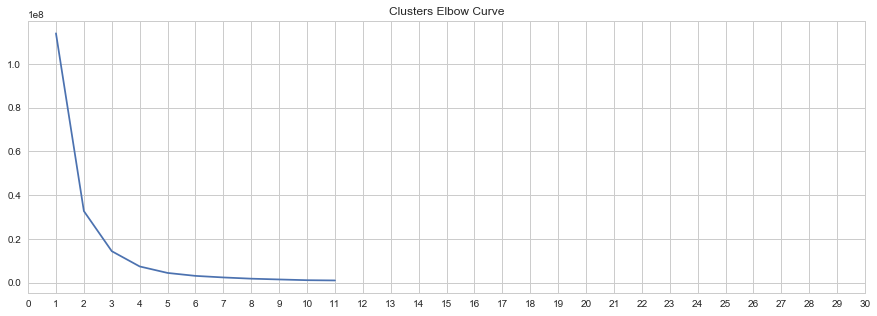

In [92]:

#Run on attendance
elbow_curve(X_time)

In [93]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
n_clusters = (2,3, 4, 5,6,7, 10, 15, 20)
for n in n_clusters:
    print("Number of estimated clusters: {}".format(n))
    for sample in [X_time]:
        model = KMeans(n_clusters=n, random_state=42).fit(sample)
        labels = model.labels_
        print(metrics.silhouette_score(sample, labels, metric='euclidean', sample_size = 15000))

Number of estimated clusters: 2
0.6062933427521618
Number of estimated clusters: 3
0.6041003622084031
Number of estimated clusters: 4
0.6055036801445978
Number of estimated clusters: 5
0.6056379771090102
Number of estimated clusters: 6
0.6038985406389378
Number of estimated clusters: 7
0.6094160809003603
Number of estimated clusters: 10
0.6439853581026376
Number of estimated clusters: 15
0.7726398867365339
Number of estimated clusters: 20
0.9157850873955259


In [94]:
model = KMeans(n_clusters=3, random_state=42).fit(X_time)
labels = model.labels_
#print(metrics.silhouette_score(sample, labels, metric='euclidean'))

X_timedf['clusters_loc'] = labels

In [95]:

X_time_clusters = X_timedf.groupby(['clusters_loc'], as_index=False).mean()
print(X_time_clusters)

   clusters_loc  fare_amount  pickup_longitude  pickup_latitude  \
0             0       11.071           -73.976           40.750   
1             1       11.208           -73.974           40.754   
2             2       11.964           -73.979           40.744   

   dropoff_longitude  dropoff_latitude  month   hour  weekday  \
0            -73.976            40.751  6.246 19.586    2.964   
1            -73.975            40.753  6.270 11.172    2.866   
2            -73.969            40.746  6.332  2.291    3.760   

   distance_traveled  
0              0.033  
1              0.032  
2              0.041  


In [ ]:
X_timedf

In [96]:
X_time_clusters

clusters_loc  fare_amount  pickup_longitude  pickup_latitude  \
0             0       11.071           -73.976           40.750   
1             1       11.208           -73.974           40.754   
2             2       11.964           -73.979           40.744   

   dropoff_longitude  dropoff_latitude  month   hour  weekday  \
0            -73.976            40.751  6.246 19.586    2.964   
1            -73.975            40.753  6.270 11.172    2.866   
2            -73.969            40.746  6.332  2.291    3.760   

   distance_traveled  
0              0.033  
1              0.032  
2              0.041

In [97]:
import folium
#-74.5, -72.8, 40.5, 41.8
lat_center_nyc = 40.7128
lon_center_nyc = -74.0060

map_nyc_pk = folium.Map(location=[lat_center_nyc,lon_center_nyc],
                         tiles="OpenStreetMap",
                         max_zoom=15,zoom_start=15)


#plotting 2500 dta points
for i in range(0,len(X_time_clusters)) :
    p = [X_timedf["pickup_latitude"].values[i],
        X_timedf["pickup_longitude"].values[i]]
    
    folium.Circle(location = p ,radius = 4,
                  color = "red").add_to(map_nyc_pk)
    

map_nyc_pk

## Supervised Modeling on the Entire Dataset

In [98]:
y_train = taxi_train_data['fare_amount']
X_train = taxi_train_data.drop('fare_amount', axis=1)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42, test_size=0.40)

## Linear Regression

In [100]:
from sklearn import linear_model
# Instantiate and fit our model.# Instan 
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_train, y_train))


Coefficients: 
 [ 9.59571322e+00  5.50223356e+00 -6.87924792e+00 -1.55755206e+01
  3.68616781e-02  9.89275606e-03 -3.68441187e-02  2.13596357e+02]

Intercept: 
 615.2458514235018

R-squared:
0.7830976050382801


## Huber Regression

In [101]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

hr.fit(X_train, y_train)
print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))
print('score: ' + str(hr.score(X_train, y_train)))

coefficients: [-1.32807933e+00 -7.90575618e-01 -3.61412941e+00 -8.12296987e+00
  2.53885324e-02  1.27916479e-02 -4.36191565e-02  2.17126643e+02]
intercept: 0.7761183265608324
score: 0.7774093761508332


## Gradient Boosting

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#start_time = time.time()
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'random_state': 42,
          'max_depth': 2,
          'loss': 'huber'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)


clf_cv = cross_val_score(clf, X_train, y_train, cv=5)
X_test2 = X_test.reshape(-1, 1)
#print("---Gradient Boosting Classifier %s seconds ---" % (time.time() - start_time))
#Test
y_true, y_pred = y_test, clf.predict(X_test2)

print("Test Set score = {:.3} ".format(clf.score(y_true, y_pred)))


print("Training set Cross validation = {}".format(clf_cv))
print("mean = {:.3}".format(clf_cv.mean()))
print(pd.crosstab(y_true, y_pred))

In [ ]:

GB_feature_graph = GB_feature_importances['importance'].nlargest(10)
plt.xlabel('Relative importance', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title("GBM Feature Importance", fontsize=20)
GB_feature_graph.plot.barh()

## Random Forest Regressor

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#start_time = time.time()

rfc1 = ensemble.RandomForestRegressor(random_state=42)
rfc1.fit(X_train,y_train)
cv1 = cross_val_score(rfc1, X_train, y_train, cv=5)

#print("---RFC takes %s seconds ---" % (time.time() - start_time))
X_test1 = X_test1.reshape(-1, 1)
#Test
y_true, y_pred = y_test, rfc1.predict(X_test1)
print("Test Set score = {:.3} ".format(clf.score(y_true, y_pred)))


print("Training set Cross validation = {}".format(cv1))
print("mean = {:.3}".format(cv1.mean()))
print(pd.crosstab(y_true, y_pred))


In [108]:
X_test

pickup_longitude  pickup_latitude  dropoff_longitude  \
2654629           -73.972           40.745            -73.986   
443453            -73.950           40.785            -73.970   
62493             -73.804           40.700            -73.808   
1809254           -73.992           40.696            -73.980   
1305177           -73.994           40.727            -73.992   
447507            -74.008           40.726            -73.986   
1512123           -73.994           40.740            -74.012   
2701131           -73.995           40.756            -73.991   
840975            -74.008           40.723            -73.873   
81249             -73.985           40.747            -73.979   
1405951           -73.982           40.746            -73.970   
1408197           -73.983           40.777            -73.955   
66840             -73.982           40.749            -73.864   
1468266           -73.977           40.743            -73.986   
2500498           -73.955           40.777            -73.944   
1252902           -73.973           40.758            -73.949   
2503362           -73.993           40.758            -73.990   
1918316           -73.938           40.797            -73.960   
212252            -73.977           40.752            -73.969   
2745606           -74.006           40.748            -74.006   
704982            -73.986           40.753            -73.945   
2656409           -73.976           40.761            -73.978   
390888            -73.993           40.731            -73.974   
1365256           -73.987           40.721            -73.974   
2582399           -73.972           40.763            -73.996   
2401989           -74.026           40.847            -73.988   
108533            -73.981           40.742            -73.978   
810516            -73.955           40.783            -73.974   
1211970           -73.998           40.724            -74.016   
144379            -73.955           40.770            -73.956   
...                   ...              ...                ...   
2032610           -73.993           40.746            -73.966   
2277619           -73.991           40.733            -73.996   
2155444           -73.996           40.731            -73.987   
1075452           -73.989           40.741            -73.974   
1108353           -74.007           40.741            -74.002   
2316603           -73.979           40.763            -74.000   
1708894           -73.989           40.740            -73.976   
384700            -73.978           40.753            -73.970   
1656248           -73.976           40.745            -73.984   
1801199           -73.989           40.749            -73.978   
2000828           -73.983           40.772            -74.177   
1782605           -73.948           40.782            -73.968   
2405018           -73.965           40.756            -73.948   
1946692           -73.970           40.762            -73.958   
941138            -73.866           40.771            -74.009   
1868365           -74.005           40.730            -73.999   
592273            -73.994           40.759            -73.988   
136471            -73.956           40.764            -73.988   
133497            -73.871           40.774            -73.871   
207683            -73.973           40.756            -73.987   
116418            -73.982           40.768            -74.177   
2278220           -73.996           40.764            -74.017   
1975888           -73.955           40.789            -73.977   
2678781           -73.963           40.770            -73.983   
10656             -74.009           40.703            -73.963   
2590416           -73.984           40.781            -73.970   
2710745           -73.986           40.779            -74.177   
2719381           -73.981           40.748            -73.973   
2645410           -73.991           40.746            -73.956   
355437            -73.994           40.743  

pickup_longitude  pickup_latitude  dropoff_longitude  \
125598            -73.997           40.757            -74.016   
763390            -74.006           40.718            -73.999   
2179837           -73.964           40.771            -73.991   
2345165           -73.992           40.750            -73.990   
573725            -73.972           40.761            -73.982   
1573445           -74.003           40.733            -74.005   
1163457           -73.983           40.726            -73.991   
2326597           -73.866           40.771            -73.963   
102097            -73.977           40.785            -73.955   
1927121           -73.871           40.774            -73.978   
1938462           -73.992           40.763            -73.975   
2189689           -73.986           40.752            -73.978   
1781906           -73.994           40.719            -73.999   
929468            -73.981           40.753            -73.988   
1224305           -73.988           40.720            -73.967   
864807            -73.982           40.773            -73.958   
921282            -73.996           40.724            -73.993   
177545            -73.777           40.645            -73.973   
1027043           -73.994           40.718            -73.950   
2415565           -74.005           40.737            -73.981   
1625805           -73.982           40.729            -73.970   
1554126           -73.982           40.767            -73.985   
2176452           -73.983           40.762            -73.873   
2017953           -73.975           40.737            -73.980   
2125390           -73.871           40.774            -73.943   
478849            -73.999           40.745            -73.967   
66479             -73.991           40.730            -73.981   
2141005           -74.006           40.746            -74.002   
589005            -74.002           40.741            -73.991   
607024            -73.983           40.772            -73.982   
...                   ...              ...                ...   
937963            -73.959           40.810            -73.966   
2642847           -73.985           40.763            -73.982   
1337222           -73.982           40.772            -73.972   
1012018           -73.995           40.725            -73.983   
1504001           -74.008           40.715            -73.973   
1427866           -73.972           40.761            -73.980   
2334332           -73.964           40.774            -73.974   
1291551           -73.978           40.779            -73.953   
105782            -73.984           40.770            -73.990   
809691            -73.975           40.734            -73.973   
1867330           -73.999           40.745            -73.995   
334529            -73.975           40.730            -73.984   
1807272           -73.963           40.769            -73.970   
1401731           -73.980           40.742            -73.983   
805048            -73.977           40.751            -73.991   
336887            -74.002           40.731            -73.987   
2187301           -73.983           40.772            -73.974   
284517            -73.995           40.732            -73.990   
1268190           -73.995           40.734            -73.982   
2324531           -73.986           40.753            -73.981   
1161974           -73.982           40.777            -73.981   
2049185           -73.990           40.727            -73.988   
1605818           -73.950           40.785            -73.949   
2285790           -74.008           40.732            -74.014   
748825            -73.995           40.740            -73.988   
112861            -73.982           40.774            -73.975   
1731417           -73.999           40.755            -73.988   
2410486           -73.991           40.751            -73.986   
2280274           -73.965           40.767            -73.994   
2270052           -73.956           40.779  

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as msq
import xgboost as xgb

stdscaler = StandardScaler()
xgb_train_X = stdscaler.fit_transform(train_X)
xgb_test_X  = stdscaler.fit_transform(test_X)

x_train, x_test, y_train, y_test = train_test_split(xgb_train_X, train_y, random_state=70, test_size=0.2)

def XGBmodel(x_train,x_test,y_train,y_test):
    matrix_train = xgb.DMatrix(x_train, label=y_train)
    matrix_test = xgb.DMatrix(x_test, label=y_test)
    model=xgb.train(params={'objective':'reg:linear','eval_metric':'rmse'},
                    dtrain=matrix_train,
                    num_boost_round=100, 
                    early_stopping_rounds=10,
                    evals=[(matrix_test,'test')])
    return model

xgb_model = XGBmodel(x_train,x_test,y_train,y_test)
xgb_pred = xgb_model.predict(xgb.DMatrix(xgb_test_X), ntree_limit = xgb_model.best_ntree_limit)

ModuleNotFoundError: No module named 'xgboost'